### Regression using LightGBM

This dataset is avaliable on

http://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant


The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. 

Features consist of hourly average ambient variables 
1. Temperature (AT)
2. Exhaust Vacuum (V) 
3. Ambient Pressure (AP)
4. Relative Humidity (RH) 
5. hourly electrical energy output (EP) --> Predctions

A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.

For comparability with our baseline studies, and to allow 5x2 fold statistical tests be carried out, we provide the data shuffled five times. For each shuffling 2-fold CV is carried out and the resulting 10 measurements are used for statistical testing.

###### Soulution:
Training a xgboost regression on provided data after combining all five shffled sheets

In [1]:
# inputs
datapath = './CCPP/'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error
import lightgbm as lgb
from lightgbm import LGBMRegressor


print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('sklearn:', pd.__version__)
print('lightgbm:', lgb.__version__)

%matplotlib inline

pandas: 0.21.0
numpy: 1.13.3
sklearn: 0.21.0
lightgbm: 2.0.11


In [3]:
# read data sets
df = pd.read_excel(datapath + 'Folds5x2_pp.xlsx',sheet_name=['Sheet1','Sheet2','Sheet3','Sheet4','Sheet5'])
df = pd.concat(df).reset_index()
df.drop(['level_0','level_1'],axis=1,inplace=True)

df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [4]:
# Sampling
trainx, valx, trainy, valy = train_test_split(df.drop(['PE'],axis=1),df['PE'],test_size=.3,random_state =2017)

In [5]:
# Define categorical features here
cat_f = []

In [6]:
# Creating dmatrix for training and validation
if len(cat_f) == 0:
    dtrain = lgb.Dataset(data=trainx,label=trainy)
    dval = lgb.Dataset(data=valx,label=valy)
else :
    dtrain = lgb.Dataset(data=trainx,label=trainy,categorical_feature=cat_f)
    dval = lgb.Dataset(data=valx,label=valy,categorical_feature=cat_f)    

In [7]:
# defining xgb parameters
parms = {'boosting': 'gbdt', #gbdt/dart/rf
         'objective': 'regression', 
         'eval_metric': 'rmse',
         'learning_rate': 0.5,
         'max_depth': 1,
         'min_data_in_leaf' : 20,
         'feature_fraction' : .9, 'feature_fraction_seed': 1,
         'verbose': 0,
         'num_leaves': 20,
         'bagging_fraction': 0.95, 'bagging_freq': 1, 'bagging_seed': 1,
         'max_bin': 256, 'min_data_in_bin': 10,
         'max_depth': 10,
         'drop_rate' : .001, # it booster is dart 
         'metric' : 'rmse',
         'data_random_seed': 10}


# Cross validation
cv_lgb = lgb.cv(params = parms, 
                train_set = dtrain, 
                num_boost_round = 5000, # provide big number if booster is gblinear
                nfold = 5,
                stratified = False, # for regression problem
                early_stopping_rounds = 5,
                verbose_eval = 10) # Look for early stopping that minimizes error

C:\Users\sivaji.doguparthi\AppData\Local\Continuum\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


[10]	cv_agg's rmse: 3.62114 + 0.128928
[20]	cv_agg's rmse: 3.31423 + 0.111657
[30]	cv_agg's rmse: 3.12049 + 0.1307
[40]	cv_agg's rmse: 2.97495 + 0.135132
[50]	cv_agg's rmse: 2.85506 + 0.119464
[60]	cv_agg's rmse: 2.75345 + 0.118695
[70]	cv_agg's rmse: 2.67188 + 0.122806
[80]	cv_agg's rmse: 2.59989 + 0.119188
[90]	cv_agg's rmse: 2.53416 + 0.105981
[100]	cv_agg's rmse: 2.48033 + 0.108773
[110]	cv_agg's rmse: 2.42778 + 0.100517
[120]	cv_agg's rmse: 2.37332 + 0.1022
[130]	cv_agg's rmse: 2.32953 + 0.101927
[140]	cv_agg's rmse: 2.28261 + 0.100394
[150]	cv_agg's rmse: 2.24301 + 0.0972094
[160]	cv_agg's rmse: 2.20171 + 0.0949795
[170]	cv_agg's rmse: 2.16312 + 0.095824
[180]	cv_agg's rmse: 2.13033 + 0.0967116
[190]	cv_agg's rmse: 2.10256 + 0.0981878
[200]	cv_agg's rmse: 2.06843 + 0.100802
[210]	cv_agg's rmse: 2.0367 + 0.101641
[220]	cv_agg's rmse: 2.00492 + 0.0972329
[230]	cv_agg's rmse: 1.97777 + 0.0965827
[240]	cv_agg's rmse: 1.95106 + 0.0980754
[250]	cv_agg's rmse: 1.92789 + 0.0948335
[260]	

[2040]	cv_agg's rmse: 0.720526 + 0.120159
[2050]	cv_agg's rmse: 0.719412 + 0.120467
[2060]	cv_agg's rmse: 0.718324 + 0.120511
[2070]	cv_agg's rmse: 0.717091 + 0.120795
[2080]	cv_agg's rmse: 0.715501 + 0.121383
[2090]	cv_agg's rmse: 0.714409 + 0.121065
[2100]	cv_agg's rmse: 0.713182 + 0.121114
[2110]	cv_agg's rmse: 0.71216 + 0.121296
[2120]	cv_agg's rmse: 0.710906 + 0.121517
[2130]	cv_agg's rmse: 0.709635 + 0.121791
[2140]	cv_agg's rmse: 0.708425 + 0.121932
[2150]	cv_agg's rmse: 0.707236 + 0.122179
[2160]	cv_agg's rmse: 0.706062 + 0.122197
[2170]	cv_agg's rmse: 0.705137 + 0.12239
[2180]	cv_agg's rmse: 0.703861 + 0.122581
[2190]	cv_agg's rmse: 0.702851 + 0.122985
[2200]	cv_agg's rmse: 0.701984 + 0.123232
[2210]	cv_agg's rmse: 0.70075 + 0.12351
[2220]	cv_agg's rmse: 0.699435 + 0.123833
[2230]	cv_agg's rmse: 0.697977 + 0.124287
[2240]	cv_agg's rmse: 0.697088 + 0.124593
[2250]	cv_agg's rmse: 0.696383 + 0.124668
[2260]	cv_agg's rmse: 0.695256 + 0.124851
[2270]	cv_agg's rmse: 0.694296 + 0.124

In [8]:
# Training
trainrounds = len(list(cv_lgb.values())[0]) # You can give it manually

fit_lgb = lgb.train(params=parms,
                    train_set = dtrain,
                    valid_sets = [dtrain,dval],
                    valid_names = ['train','val'],
                    num_boost_round=trainrounds,
                    verbose_eval=50)

[50]	train's rmse: 2.63652	val's rmse: 2.82109


C:\Users\sivaji.doguparthi\AppData\Local\Continuum\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


[100]	train's rmse: 2.164	val's rmse: 2.42077
[150]	train's rmse: 1.88028	val's rmse: 2.15018
[200]	train's rmse: 1.67563	val's rmse: 1.96446
[250]	train's rmse: 1.49874	val's rmse: 1.80132
[300]	train's rmse: 1.35916	val's rmse: 1.67583
[350]	train's rmse: 1.24223	val's rmse: 1.55418
[400]	train's rmse: 1.13521	val's rmse: 1.44597
[450]	train's rmse: 1.05223	val's rmse: 1.3633
[500]	train's rmse: 0.969531	val's rmse: 1.28266
[550]	train's rmse: 0.89741	val's rmse: 1.21039
[600]	train's rmse: 0.831426	val's rmse: 1.13724
[650]	train's rmse: 0.776827	val's rmse: 1.08262
[700]	train's rmse: 0.723338	val's rmse: 1.02608
[750]	train's rmse: 0.675032	val's rmse: 0.970767
[800]	train's rmse: 0.631202	val's rmse: 0.919755
[850]	train's rmse: 0.594278	val's rmse: 0.87667
[900]	train's rmse: 0.560879	val's rmse: 0.838914
[950]	train's rmse: 0.530634	val's rmse: 0.805861
[1000]	train's rmse: 0.500203	val's rmse: 0.768898
[1050]	train's rmse: 0.474349	val's rmse: 0.735764
[1100]	train's rmse: 0.4

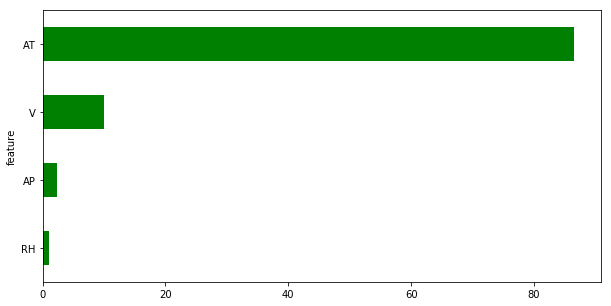

In [9]:
# fig, ax = plt.subplots(figsize=(10, 12))
gain = fit_lgb.feature_importance('gain')
ft = pd.DataFrame({'feature':fit_lgb.feature_name(), 'split':fit_lgb.feature_importance('split'), 'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
ft = ft.sort_values('gain',ascending=True)
ft[['feature','gain']].head(25).plot(kind='barh', x='feature', y='gain', legend=False, figsize=(10, 5),color='g')

In [10]:
def GetEvalMetrics(y_true, y_pred): 
    y_true = y_true.as_matrix()
    y_pred = y_pred.as_matrix()
    return round((1 - np.sum((y_true-y_pred)**2)/np.sum((y_true-np.mean(y_true))**2)),4), \
        round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100,4)

In [11]:
valprd = pd.DataFrame({'Actual':dval.get_label(),'Predicted':fit_lgb.predict(valx)})
_, vMAPE = GetEvalMetrics(valprd['Actual'],valprd['Predicted'])

trnprd = pd.DataFrame({'Actual':dtrain.get_label(),'Predicted':fit_lgb.predict(trainx)})
_, tMAPE = GetEvalMetrics(trnprd['Actual'],trnprd['Predicted'])

In [12]:
print('Train Metrics:\n')
print('R_Sqr: ',r2_score(trnprd['Actual'],trnprd['Predicted']))
print('RMSE: ',np.sqrt(mean_squared_error(trnprd['Actual'],trnprd['Predicted'])))
print('MAPE: ',tMAPE)
print('Mean Absult Error: ',mean_absolute_error(trnprd['Actual'],trnprd['Predicted']))
print('Median Absult Error: ',median_absolute_error(trnprd['Actual'],trnprd['Predicted']))

print('\nValdation Metrics:\n')
print('R_Sqr: ',r2_score(valprd['Actual'],valprd['Predicted']))
print('RMSE: ',np.sqrt(mean_squared_error(valprd['Actual'],valprd['Predicted'])))
print('MAPE: ',vMAPE)
print('Mean Absult Error: ',mean_absolute_error(valprd['Actual'],valprd['Predicted']))
print('Median Absult Error: ',median_absolute_error(valprd['Actual'],valprd['Predicted']))

Train Metrics:

R_Sqr:  0.999960292128
RMSE:  0.107296202318
MAPE:  0.0113
Mean Absult Error:  0.0512098996814
Median Absult Error:  0.0307988686703

Valdation Metrics:

R_Sqr:  0.999752384632
RMSE:  0.269963490711
MAPE:  0.0231
Mean Absult Error:  0.104483155023
Median Absult Error:  0.0480080266391


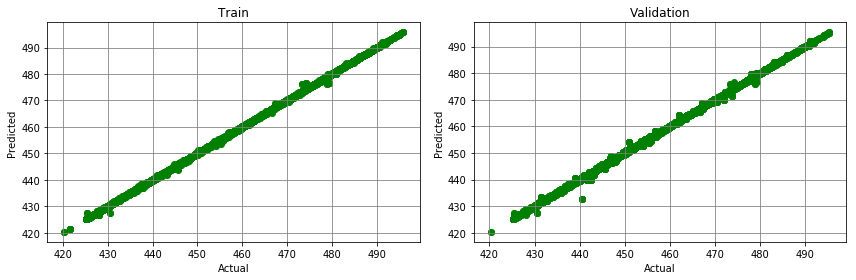

In [13]:
plt.rcParams['figure.figsize'] = (12, 4)
plt.rc('grid', linestyle="-",color='grey')
plt.subplot(1,2,1)
plt.scatter(trnprd.Actual,trnprd.Predicted,color='green')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Train')
plt.grid(True)
plt.subplot(1,2,2)
plt.scatter(valprd.Actual,valprd.Predicted,color='green')
plt.title('Validation')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.grid(True)
plt.show()

In [14]:
# Save model
fit_lgb.save_model('./model.txt')

In [15]:
# load model and score
scoremodel = lgb.Booster(model_file='./model.txt')
scoremodel.predict(valx)

array([ 456.32981234,  427.22199264,  443.5769766 , ...,  425.68053739,
        470.90896545,  479.96941679])